# Data Processing

## Load

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/face/training.csv')
df.shape

(7049, 31)

In [3]:
# labels
features = df.drop('Image', axis=1)

In [4]:
# checking columns with any null value
features.columns[features.isna().any()]

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='object')

In [5]:
# number of null of "left_eye_center_x"
# should be the same for y (checked it)
features["left_eye_center_x"].isna().sum()

10

In [6]:
# number of null of "righteye_center_x"
features["right_eye_center_x"].isna().sum()

13

In [7]:
# number of null of "mouth_center_bottom_lip_x"
features["mouth_center_bottom_lip_x"].isna().sum()

33

In [8]:
# considering 10+13+33 is not that many,
# rows with these conditions will be dropped.
# there's probably a better way with drop() but.. I dunno.
features = features[features["left_eye_center_x"].notna()]
features = features[features["right_eye_center_x"].notna()]
features = features[features["mouth_center_bottom_lip_x"].notna()]

In [9]:
# 49 rows are dropped
features.shape

(7000, 30)

In [10]:
# making sure these 4 features(x,y) doesn't include any null values
features.columns[features.notna().all()]

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='object')

In [11]:
# none of the columns were dropped
features.columns.shape

(30,)

## Split into training/validation/test data

### Training Data

In [12]:
# include ALL non-null values
train_df = features.dropna()

In [13]:
train_df.shape

(2140, 30)

### Test Data

In [14]:
# include ANY null values
test_df = features[features.isna().any(axis=1)]

In [15]:
test_df.shape

(4860, 30)

In [19]:
# test data predictor
x_test = test_df[features.columns[features.notna().all()].tolist()]

In [22]:
x_test.shape

(4860, 8)

### Split training/validation data

In [23]:
# features without null are used as indepdent variable
x = train_df[features.columns[features.notna().all()].tolist()]

In [24]:
x.shape

(2140, 8)

In [25]:
# features with null are used as dependent variable
y = train_df[features.columns[features.isna().any()].tolist()]

In [26]:
y.shape

(2140, 22)

In [27]:
# separate training dataset, validation dataset
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [28]:
# x data train set, x data validation set
x_train.shape, x_val.shape

((1712, 8), (428, 8))

In [30]:
# y data train set, y data validation set
y_train.shape, y_val.shape

((1712, 22), (428, 22))

In [31]:
xy_var = train_df.values

In [32]:
# prepare for standardization
mu = xy_var.mean()
sigma = xy_var.std()
mu, sigma

(47.58567997859572, 18.82775732743113)

In [33]:
# standardize
x_train_norm = (x_train - mu)/sigma
x_val_norm = (x_val - mu)/sigma
x_test_norm = (x_test - mu)/sigma

In [37]:
# x training dataset shape
x_train_norm.shape

(1712, 8)

In [38]:
# x validation dataset shape
x_val_norm.shape

(428, 8)

## Visual Check
    image index must equal to features index

In [39]:
features.shape, train_df.shape, test_df.shape

((7000, 30), (2140, 30), (4860, 30))

In [40]:
# using this index, it's possible to select imgs
df.loc[train_df.index].shape

(2140, 31)

In [41]:
# using parallel processing
# 10 threads
# to separate "image" section into var x
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

# ref: https://joblib.readthedocs.io/en/latest/parallel.html
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in df.loc[train_df.index].Image)
    
train_img = np.stack(train_img)[..., None]
train_img.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    5.9s finished


(2140, 96, 96, 1)

In [42]:
# uses matplotlib to graph picture based on "image" data
def show(img, dots=None):
    plt.imshow(img[..., 0], "gray")
    # plots y (label) data on top
    if dots is not None:
        points = np.vstack(np.split(dots, 15)).T
        plt.plot(points[0], points[1], 'o', color='yellow')
        
    plt.axis('off')

In [43]:
train_dots = train_df.iloc[:].values
train_dots.shape

(2140, 30)

In [44]:
train_img.shape

(2140, 96, 96, 1)

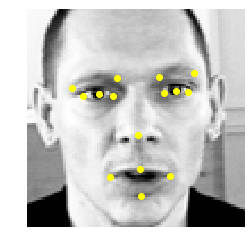

In [55]:
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_dots[sample_idx])

In [46]:
test_dots = test_df.iloc[:].values
test_dots.shape

(4860, 30)

In [47]:
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in df.loc[test_df.index].Image)
    
test_img = np.stack(test_img)[..., None]
test_img.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done 4860 out of 4860 | elapsed:   13.7s finished


(4860, 96, 96, 1)

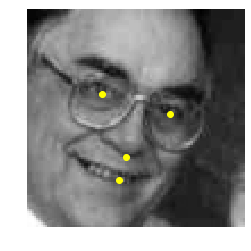

In [59]:
sample_idx = np.random.choice(len(test_img))
show(test_img[sample_idx], test_dots[sample_idx])

# Model

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [61]:
x_train_norm.shape

(1712, 8)

In [62]:
y_train.shape

(1712, 22)

In [67]:
model = Sequential([
    Dense(24, input_shape = (8,),
          activation = 'relu', 
          use_bias = True,
          bias_initializer='he_normal',
          bias_regularizer=regularizers.l2(0.01),
          kernel_initializer='he_normal', 
          kernel_regularizer=regularizers.l2(0.01)),
    Dense(64, activation = 'relu', 
          use_bias = True,
          bias_initializer='he_normal',
          bias_regularizer=regularizers.l2(0.01),
          kernel_initializer='he_normal', 
          kernel_regularizer=regularizers.l2(0.01)),
    Dense(22, activation='relu',
          use_bias = True,
          bias_initializer='he_normal',
          bias_regularizer=regularizers.l2(0.01),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.01))
])

model.compile(optimizer=Adam(0.001),loss='mse',metrics=['mae'])

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1600      
_________________________________________________________________
dense_5 (Dense)              (None, 22)                1430      
Total params: 3,246
Trainable params: 3,246
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.input, model.output

(<tf.Tensor 'dense_3_input:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'dense_5/Relu:0' shape=(?, 22) dtype=float32>)

In [70]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=5, min_lr=0.0001)

# 100 epochs is most preferrable
# by making an instance of model.fit(),
# we can make analysis of the training process.
log = model.fit(x_train_norm, 
                y_train, 
                epochs = 100,
                batch_size = 10,
                validation_data=[x_val_norm, y_val],
                callbacks=[reduce_lr], verbose=2)

Train on 1712 samples, validate on 428 samples
Epoch 1/100
 - 2s - loss: 1809.8199 - mean_absolute_error: 36.8998 - val_loss: 469.9579 - val_mean_absolute_error: 16.2679
Epoch 2/100
 - 1s - loss: 269.4703 - mean_absolute_error: 10.3763 - val_loss: 234.9557 - val_mean_absolute_error: 9.1068
Epoch 3/100
 - 1s - loss: 233.2855 - mean_absolute_error: 8.9786 - val_loss: 233.4430 - val_mean_absolute_error: 8.9705
Epoch 4/100
 - 1s - loss: 232.1359 - mean_absolute_error: 8.8872 - val_loss: 232.4533 - val_mean_absolute_error: 8.8816
Epoch 5/100
 - 1s - loss: 231.0407 - mean_absolute_error: 8.7934 - val_loss: 231.5749 - val_mean_absolute_error: 8.8095
Epoch 6/100
 - 1s - loss: 191.9875 - mean_absolute_error: 7.6786 - val_loss: 126.6241 - val_mean_absolute_error: 5.8971
Epoch 7/100
 - 1s - loss: 125.5879 - mean_absolute_error: 5.7829 - val_loss: 126.3264 - val_mean_absolute_error: 5.8877
Epoch 8/100
 - 1s - loss: 124.6954 - mean_absolute_error: 5.6869 - val_loss: 124.8223 - val_mean_absolute_err

Epoch 70/100
 - 1s - loss: 6.7326 - mean_absolute_error: 1.5154 - val_loss: 6.8178 - val_mean_absolute_error: 1.5165
Epoch 71/100
 - 1s - loss: 6.7133 - mean_absolute_error: 1.5082 - val_loss: 6.6623 - val_mean_absolute_error: 1.4896
Epoch 72/100
 - 1s - loss: 6.7087 - mean_absolute_error: 1.5071 - val_loss: 6.6980 - val_mean_absolute_error: 1.4954
Epoch 73/100
 - 1s - loss: 6.6495 - mean_absolute_error: 1.4978 - val_loss: 6.9502 - val_mean_absolute_error: 1.5370
Epoch 74/100
 - 1s - loss: 6.6897 - mean_absolute_error: 1.5065 - val_loss: 6.6714 - val_mean_absolute_error: 1.4935
Epoch 75/100
 - 1s - loss: 6.6627 - mean_absolute_error: 1.4999 - val_loss: 6.6796 - val_mean_absolute_error: 1.4875
Epoch 76/100
 - 1s - loss: 6.6408 - mean_absolute_error: 1.4962 - val_loss: 6.6376 - val_mean_absolute_error: 1.4850
Epoch 77/100
 - 1s - loss: 6.6384 - mean_absolute_error: 1.4973 - val_loss: 6.8724 - val_mean_absolute_error: 1.5569
Epoch 78/100
 - 1s - loss: 6.6506 - mean_absolute_error: 1.4998 

In [71]:
print(f'MAE final: {model.evaluate(x_val_norm, y_val)[1]}')

428/428 [==============================] - 0s 84us/step
MAE final: 1.4565509457454504


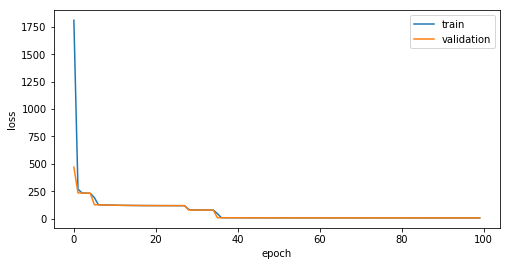

In [72]:
# graphing the training loss and validation loss
# is useful to visually check for
# overfitting/overshotting,
# or any anomaly.
def show_results(log):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(log['loss'], label='train')
    ax.plot(log['val_loss'], label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
log = log.history
show_results(log)

# Prediction

## Validation

In [73]:
def show_pred(img, dots_real, dots_pred):
    fig, axes = plt.subplots(1, 2, figsize=(5,5))
    for ax in axes:
        ax.imshow(img[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(dots_real[0], 11)).T
    points_pred = np.vstack(np.split(dots_pred[0], 11)).T
    
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

In [74]:
# calculate the difference,
# between predicted value and real value
predicted_val=model.predict(x_val_norm)
residual_val=np.abs(predicted_val - y_val)
# MAD ==> Mean Absolute Value
# 22 ==> number of labels(x+y)
# not sure why y_val is treated as mean?
mad_val=np.sum(residual_val, axis=1)/22

# indices == index
# sort by the difference
# between predicted value and real value
indices=mad_val.argsort()
indices.shape

(428,)

In [75]:
x_val_norm.shape

(428, 8)

In [76]:
y_val.shape

(428, 22)

In [78]:
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    val_img = ex(delayed(format_img)(e) for e in df.loc[x_val_norm.index].Image)
    
val_img = np.stack(val_img)[..., None]
val_img.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 428 out of 428 | elapsed:    1.1s finished


(428, 96, 96, 1)

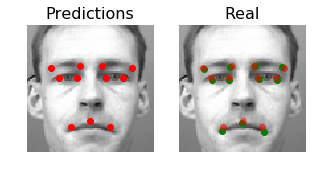

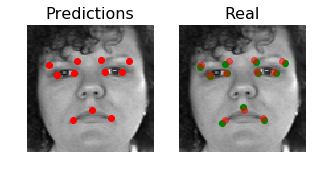

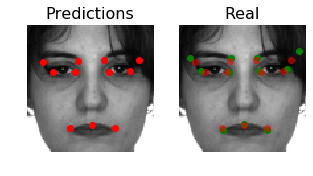

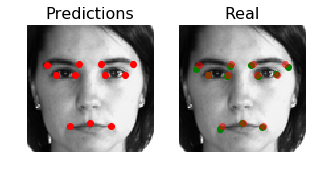

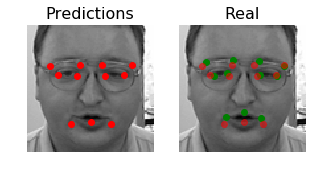

In [81]:
# Random Sample comparison
for _ in range(5):
    index = np.random.choice(x_val_norm.shape[0])
    sample_x = x_val_norm.values[index, None]
    val_real_dots = y_val.values[index, None]
    val_pred_dots = model.predict(sample_x)
    show_pred(val_img[index, None], val_real_dots, val_pred_dots)

In [100]:
# calculate the difference,
# between predicted value and real value
predicted_val=model.predict(x_val_norm)
residual_val=np.abs(predicted_val - y_val)
# MAD ==> Mean Absolute Value
# 22 ==> number of labels(x+y)
# not sure why y_val is treated as mean?
mad_val=np.sum(residual_val.values, axis=1)/22

# indices == index
# sort by the difference
# between predicted value and real value
indices=mad_val.argsort()
indices.shape

(428,)

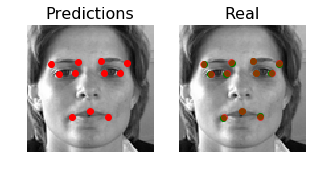

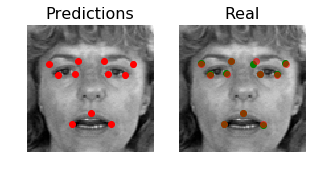

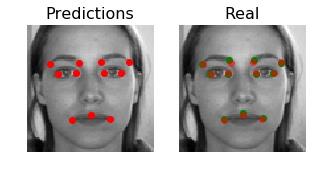

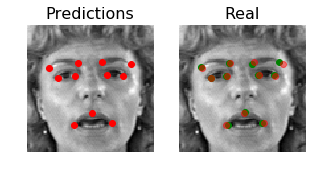

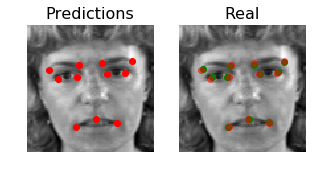

In [102]:
# Most Alike
for i in range(5):
    sample_x = x_val_norm.values[indices[i], None]
    val_real_dots = y_val.values[indices[i], None]
    val_pred_dots = model.predict(sample_x)
    show_pred(val_img[indices[i], None], val_real_dots, val_pred_dots)

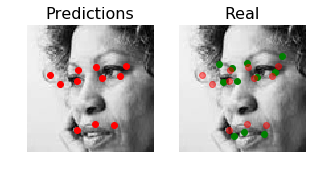

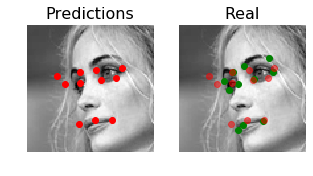

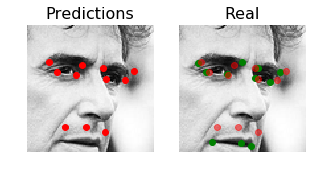

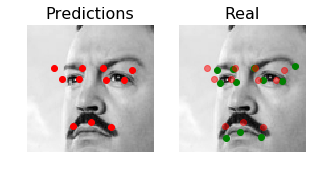

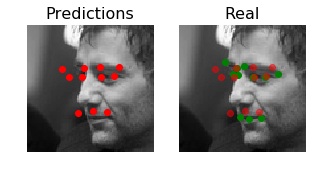

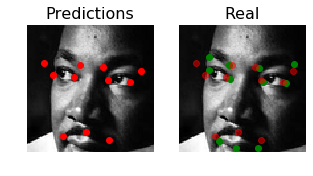

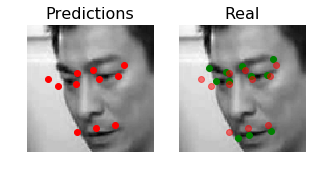

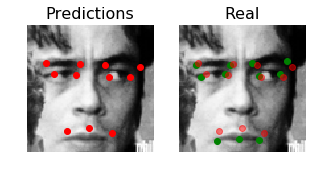

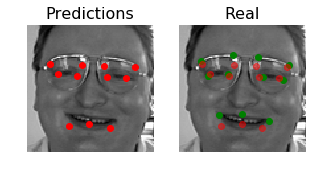

In [103]:
# Least Alike
for i in range(-1,-10,-1):
    sample_x = x_val_norm.values[indices[i], None]
    val_real_dots = y_val.values[indices[i], None]
    val_pred_dots = model.predict(sample_x)
    show_pred(val_img[indices[i], None], val_real_dots, val_pred_dots)

## FILL IN THE BLANK
    test dataset consists of rows that include at least one null value,
    the purpose of the model was to fill in the null value
    with predicted value

In [145]:
test_df.isna().sum()

left_eye_center_x               0
left_eye_center_y               0
right_eye_center_x              0
right_eye_center_y              0
left_eye_inner_corner_x      4763
left_eye_inner_corner_y      4763
left_eye_outer_corner_x      4765
left_eye_outer_corner_y      4765
right_eye_inner_corner_x     4761
right_eye_inner_corner_y     4761
right_eye_outer_corner_x     4760
right_eye_outer_corner_y     4760
left_eyebrow_inner_end_x     4764
left_eyebrow_inner_end_y     4764
left_eyebrow_outer_end_x     4806
left_eyebrow_outer_end_y     4806
right_eyebrow_inner_end_x    4767
right_eyebrow_inner_end_y    4767
right_eyebrow_outer_end_x    4799
right_eyebrow_outer_end_y    4799
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4762
mouth_left_corner_y          4762
mouth_right_corner_x         4761
mouth_right_corner_y         4761
mouth_center_top_lip_x       4755
mouth_center_top_lip_y       4755
mouth_center_bottom_lip_x       0
mouth_center_b

In [122]:
x_test_norm.head().T

,1585,1588,1598,1601,1605
left_eye_center_x,0.932769,0.854561,1.172763,1.097259,0.930088
left_eye_center_y,-0.860876,-0.640035,-0.649521,-0.681320,-0.553957
right_eye_center_x,-1.036949,-0.951041,-0.898079,-1.120307,-0.883579
right_eye_center_y,-0.352065,-0.682014,-0.689111,-0.731515,-0.712125
nose_tip_x,0.924550,0.081449,0.168356,0.039931,-0.426217
nose_tip_y,0.412201,0.606981,0.710902,0.808308,0.765486
mouth_center_bottom_lip_x,0.443506,-0.035615,0.134880,-0.065590,-0.133499
mouth_center_bottom_lip_y,1.746297,1.517903,1.793102,2.026696,1.712384


In [123]:
# make prediction with x_test_norm
test_prediction = model.predict(x_test_norm)

In [124]:
# turning predicted data to dataframe with matching index and columns
test_pred_df = pd.DataFrame(test_prediction, 
                            columns=features.columns[features.isna().any()].tolist(), 
                            index=x_test_norm.index.tolist())

In [146]:
# matching row count!
test_pred_df.shape, x_test.shape

((4860, 22), (4860, 8))

In [152]:
# concat by columns
full_test_df = pd.concat([test_pred_df, x_test], axis=1)

In [153]:
# rearrange columns by the original dataset columns index
full_test_df = full_test_df.reindex(df.columns.tolist(), axis=1)

In [154]:
full_test_df.shape

(4860, 31)

In [159]:
# adding image to corresponding index
full_test_df["Image"] = df.loc[test_df.index].Image

In [166]:
train_df.shape

(2140, 30)

In [167]:
train_df["Image"] = df.loc[train_df.index].Image

C:\Anaconda\envs\keras_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
train_df.shape

(2140, 31)

In [193]:
full_df = full_test_df.append(train_df).sort_index(axis=0)

In [198]:
full_df.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [197]:
df.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [199]:
full_df.to_csv("../data/face/training_nonull.csv", sep=",", index=False)